In [1]:
from pytorch_lightning import seed_everything
# set seed
seed = 42
seed_everything =(seed)

In [2]:
import pytorch_lightning as pl
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

In [3]:
class Resent(pl.LightningModule):

    def __init__(self):

        super(Resent, self).__init__()

#         self.params = hparams

        ########## define the model ########## 
        net = torchvision.models.resnet34(pretrained=True)
        model_weight_path = "../input/weights/resnet34.pth"
        assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
        net.load_state_dict(torch.load(model_weight_path))
        num_features = net.fc.in_features

        model = list(net.children())[:-1]  # ResNet18 has 10 children
        self.backbone = torch.nn.Sequential(*model)  # [bs, 512, 1, 1]
        self.final = torch.nn.Sequential(
            torch.nn.Linear(num_features, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, 2),
            torch.nn.Softmax(dim=1))


    def forward(self, x):
        x = self.backbone(x)
        x = x.reshape(x.size(0), -1)
        x = self.final(x)

        return x


    def configure_optimizers(self):
        optimizer = torch.optim.SGD([
            {'params': self.backbone.parameters()},
            {'params': self.final.parameters(), 'lr': 1e-2}
        ], lr=1e-3, momentum=0.9)

        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return [optimizer], [exp_lr_scheduler]

        #         return torch.optim.Adam(self.parameters(), lr=0.001)


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        _, preds = torch.max(y_hat, dim=1)
        acc = torch.sum(preds == y.data) / (y.shape[0] * 1.0)

        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'train_acc': acc}


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        _, preds = torch.max(y_hat, dim=1)
        acc = torch.sum(preds == y.data) / (y.shape[0] * 1.0)

        self.log('val_loss', loss)
        self.log('val_acc', acc)

        return {'val_loss': loss, 'val_acc': acc}


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        _, preds = torch.max(y_hat, dim=1)
        acc = torch.sum(preds == y.data) / (y.shape[0] * 1.0)

        self.log('test_loss', loss)
        self.log('test_acc', acc)

        return {'test_loss': loss, 'test_acc': acc}


    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        train_set = torchvision.datasets.ImageFolder(root='../input/dataset/dataset/training_set', transform=transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True,
                                                   num_workers=int(os.cpu_count() / 2))

        return train_loader


    def val_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        val_set = torchvision.datasets.ImageFolder(root='../input/dataset/dataset/test_set', transform=transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True,
                                                 num_workers=int(os.cpu_count() / 2))

        return val_loader


    def test_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        test_set = torchvision.datasets.ImageFolder(root='../input/dataset/dataset/test_set', transform=transform)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True,
                                                  num_workers=int(os.cpu_count() / 2))

        return test_loader


In [4]:
def main():
    model = Resent()
    trainer = Trainer(
        progress_bar_refresh_rate=20,
        max_epochs=5,
        gpus=1,
        logger=TensorBoardLogger('lightning_logs/', name='Resnet34'),
    #     callbacks=[LearningRateMonitor(logging_interval='step')],
    )

    trainer.fit(model)
    trainer.save_checkpoint("example.ckpt")
if __name__ == '__main__':
    main()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to turn'
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:840: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

class: cats   prob: 0.731


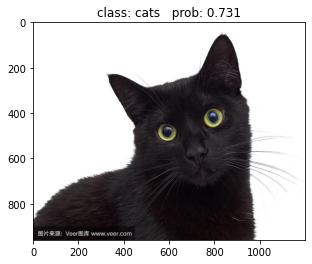

In [5]:
import os
import json
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def main():

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    img_path = "../input/catdog/hcat.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)

    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = '../input/catdog-json/class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
#     model = resnet34(num_classes=5).to(device)

    # load model weights
#     weights_path = "../input/resnet/resNet-PS.pth"
#     model.load_state_dict(torch.load(weights_path))
    model = Resent.load_from_checkpoint(checkpoint_path="./example.ckpt")
#     print(model)

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img)[0]).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3f}".format(class_indict[str(predict_cla)],
                                                  predict[predict_cla].numpy())
    plt.title(print_res)
    print(print_res)
    plt.show()


if __name__ == '__main__':
    main()


In [6]:
%load_ext tensorboard
%tensorboard --logdir=./lightning_logs